In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from math import floor, log10
from os import system

import matplotlib.colors as colors
import matplotlib.ticker as ticker
plt.style.use(f'/home/edsaa/Repositories/ReactiveBiomass/misc/edwin.mplstyle')

''' GLOBAL CONSTANTS '''
PI = np.pi
BOLTZMANN = 1.380649E-23 #N·m/K
TEMP = 10 + 273.15 #K
g = 9.81 #m/s²


def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(floor(log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\times10^{{{1:d}}}$".format(coeff, exponent, precision)

def p_notation(num) -> str:
    exponent = np.log10(num)
    return rf"$10^{{{exponent:.0f}}}$"

In [31]:
def dispCoef(D_m,alpha_L,U,n=1.0):
    return D_m + alpha_L*(U**n)

def poreVel(q, theta):
    return q/theta

def molecularDiff(visco,dp): 
    return (BOLTZMANN*TEMP)/(3*PI*visco*dp)

def attachmentRate(dc,theta,alpha,U,eta0): 
    return (3*(1-theta)*alpha*U*eta0)/(2*dc)

def collectorEff(etaD,etaI,etaG):
    return etaD + etaI + etaG

def collectorEfficiency_Diffusion(A_s,N_R,N_Pe,N_vdW):
    return 2.40 * (A_s**(1./3.)) * (N_R**-0.081) * (N_Pe**-0.715) * (N_vdW**0.052)

def collectorEfficiency_Interception(A_s,N_R,N_Pe,N_vdW):
    return 0.55 * A_s * (N_R**1.55) * (N_Pe**-0.125) * (N_vdW**0.125)

def collectorEfficiency_GDeposition(N_gr,N_R,N_Pe,N_vdW):
    return 0.475 * (N_gr**1.11)   * (N_R**-1.35)  * (N_Pe**-1.11)  * (N_vdW**0.053)

def happelParameter(theta):
    s = 1-theta
    s53 = s**(5./3.)
    s13 = s**(1./3.)
    s21 = s**2
    return (2*(1-s53))/(2 - (3*s13) + (3*s53) - (2*s21))

def noDim_SizeRatio(dp,dc):
    return dp/dc

def noDim_Péclet(q,dc,Dm):
     return q*dc/Dm

def noDim_vanderWaals(A):
    return A/(BOLTZMANN*TEMP)

def noDim_Gravitational(dp,rhof,rhop):
    return (PI*(dp**4)*(rhop-rhof)*g)/(12.*BOLTZMANN*TEMP)

In [32]:
'''CASE CONSTANTS'''
#Porosity
theta = 0.35 # adim
dc = 2.0E-3 # 2mm << sand
dp = 1.0E-7
A = 5.0E-21 # J = N·m
viscosity = 0.0008891 # N·s/m²
water_density = 999.79 # kg/m³
particle_density = 1050.0 # kg/m³ 
alpha = 0.01 # adim << favorable conditions

#Darcy flow velocity
#I = 1e-3
H = 10.
r = 40.
f = 10.
Qin = 0.24/86400.
decayRate = 3.5353E-06

In [33]:
def hydraulicCond_kozenycarman(dc:np.array) -> np.array:
    kappa = dc**2 * np.power(theta,3)/ (180 * np.power(1-theta, 2))
    return kappa * water_density * g / viscosity

K = hydraulicCond_kozenycarman(dc)
print(f"{K = :.3E} m/s")

K = 2.488E-02 m/s


In [34]:
def characteristic_q(I:np.array) -> np.array:
    return K*I + Qin*(1+f)/(4*r*H)

q = characteristic_q(I)

In [35]:
def transversal_dispersivity(q:np.array, dc:np.array, dp: float):
    Dm = molecularDiff(viscosity,dp)
    αKt, mKt = 0.025, 1.10 
    KtDm_ratio = 0.70 + αKt*np.power(dc * q/theta / Dm, mKt)
    return KtDm_ratio * Dm

def longitudinal_dispersivity(q:np.array, dc:np.array, dp: float):
    Dm = molecularDiff(viscosity,dp)
    αKl, mKl = 0.50, 1.20 
    KlDm_ratio = 0.70 + αKl*np.power(dc * q/theta / Dm, mKl)
    return KlDm_ratio * Dm

Kl = longitudinal_dispersivity(q,dc,dp)
Kt = transversal_dispersivity(q,dc,dp)

In [36]:
def katt_dp_dc(dp:np.array, dc:np.array, q:np.array):

    #Molecular diffusion
    Dm  = molecularDiff(viscosity,dp)
    
    #Pore water velocity
    U   = poreVel(q,theta)
    
    #Non-dimensional numbers
    As  = happelParameter(theta)
    NR  = noDim_SizeRatio(dp,dc)
    NPe = noDim_Péclet(q,dc,Dm)
    NvW = noDim_vanderWaals(A)
    NGr = noDim_Gravitational(dp,water_density,particle_density)
    
    #Collector efficiency
    etaD = collectorEfficiency_Diffusion(As,NR,NPe,NvW)
    etaI = collectorEfficiency_Interception(As,NR,NPe,NvW)
    etaG = collectorEfficiency_GDeposition(NGr,NR,NPe,NvW)
    eta0 = collectorEff(etaD,etaI,etaG)
    
    #Attachment rate
    kAtt = attachmentRate(dc,theta,alpha,U,eta0)

    return kAtt

katt = katt_dp_dc(dp,dc,q)

In [49]:
from scipy.special import erfc
# def dispersion_advection(xx,yy,Kl,Kt,time):
#     B = 2 * Kl / (q/theta)
#     d = 1 + 2*B*(decayRate+katt)/(q/theta)
#     r = np.sqrt(d*(xx**2+((yy**2)*Kl/Kt)))
#     u = np.power(r,2)/(4*d*Kl*time)
#     Term1 = Qin / 4 * np.sqrt(np.pi) * theta * np.sqrt(q/theta * r * Kt)
#     Term2 = np.exp(xx-r/B)
#     Term3 = erfc((2*u - r/B)/(2*np.sqrt(u)))
#     return Term1 * Term2 * Term3

def dispersion_advection(xx,yy,Kl,Kt):
    B_solver = 2 * Kl / (q/theta)
    d_solver = 1 + 2*B_solver*(decayRate + katt)/(q/theta)
    #d = 1.0
    r_solver = np.sqrt(d_solver*(xx**2+((yy**2)*Kl/Kt)))
    Term1 = (Qin) / (4 * np.sqrt(np.pi) * theta * np.sqrt(q/theta * r_solver * Kt))
    Term2 = np.exp((xx - r_solver)/B_solver)
    Term3 = 2.0
    return Term1 * Term2 * Term3


In [60]:
x = np.linspace(-10,100,500)
y = np.linspace(-2.5,2.5,200)
xx,yy = np.meshgrid(x,y)

## Calculations
I = 1e-2
q = characteristic_q(I)
Kl = longitudinal_dispersivity(q,dc,dp)
Kt = transversal_dispersivity(q,dc,dp)
katt = katt_dp_dc(dp,dc,q)
Ce = dispersion_advection(xx, yy, Kl, Kt)
Ce = -np.ma.log10(np.ma.masked_less(Ce, 1e-10))

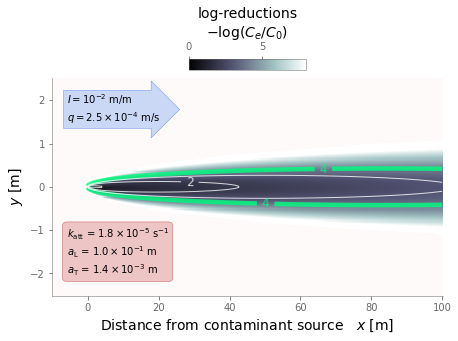

In [67]:
fig,ax = plt.subplots(figsize=(7,5))

## Colormesh
img = ax.pcolormesh(xx, yy, Ce,
    vmax=8, vmin=0,
    cmap="bone", edgecolors='face')

plt.colorbar(img, ax=ax,
    orientation='horizontal', location='top',
    label="log-reductions\n" + r"$-\log(C_e/C_0)$",
    shrink=0.3, aspect=10, anchor=(0.5, -0.2))

## Equal to 4 contour
cs = ax.contour(xx,yy, Ce, [4],
    colors=["springgreen"], alpha=0.8, linewidths=4.5)

ax.clabel(cs, cs.levels, inline=True, fmt="%.0f", 
    fontsize=12, colors=["springgreen"], manual=False)

## Below 4 contours
cs = ax.contour(xx,yy, Ce, np.arange(0,4,1),
    colors=["w"], alpha=0.8,linewidths=1.0)

ax.clabel(cs, [0, 2], inline=True, fmt="%.0f", 
    fontsize=12, colors=["w"], manual=False)

ax.set_xlabel("Distance from contaminant source   $x$ [m]")
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_ylabel("$y$ [m]")

#Summary of variables
ax.text(
    -6.0, -1.5, 
    fr"$k_{{\rm att}}$ = {sci_notation(katt)} s$^{{-1}}$" 
    + "\n" + fr"$a_{{\rm L}}$ = {sci_notation(Kl/(q*theta))} m"
    + "\n" + fr"$a_{{\rm T}}$ = {sci_notation(Kt/(q*theta))} m", 
    rotation=0, size=10, ha='left', va='center',
    bbox=dict(boxstyle="round,pad=0.4", fc="#CD5C5C55", ec="indianred", lw=0.5))

#Flow direction arrow
ax.text(
    -6, 1.8, f"$I = ${p_notation(I)} m/m\n$q = ${sci_notation(q)} m/s", rotation=0, size=10,
    zorder=10, ha='left', va='center',
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="#6495ed55", ec="cornflowerblue", lw=0.5))

plt.show()

In [ ]:
# fig,axs = plt.subplots(3,1, figsize=(6,12), sharex=True, sharey=True, 
#     gridspec_kw={'hspace':0.05})

# for ax,I in zip(axs,[1e-3,1e-2,1e-1]):
    
#     ## Calculations
#     q = characteristic_q(I)
#     Kl = longitudinal_dispersivity(q,dc,dp)
#     Kt = transversal_dispersivity(q,dc,dp)
#     katt = katt_dp_dc(dp,dc,q)
#     Ce = dispersion_advection(xx, yy, Kl, Kt)
#     Ce = -np.ma.log10(np.ma.masked_less(Ce, 1e-30))
    
#     ## Colormesh
#     img = ax.pcolormesh(
#         xx,yy,
#         Ce,
#         cmap="bone",
#         edgecolors='face',
#         vmax=10, vmin=0)

#     ## Below 4 contours
#     cs = ax.contour(xx,yy, Ce, np.arange(0,4,1),
#         colors=["w"], alpha=0.8,linewidths=1.5)

#     ax.clabel(cs, cs.levels, inline=True, fmt="%.0f", 
#         fontsize=12, colors=["w"],
#         manual=False)

#     ## Equal to 4 contour
#     cs = ax.contour(xx,yy, Ce, [4],
#         colors=["springgreen"], alpha=0.8, linewidths=4.5)

#     ax.clabel(cs, cs.levels, inline=True, fmt="%.0f", 
#         fontsize=12, colors=["springgreen"],
#         manual=False)

#     ## Greater than 4 contour
#     cs = ax.contour(xx,yy, Ce, np.arange(5,10,1),
#         colors=["k"], alpha=0.8, linewidths=1.0)

#     ax.clabel(cs, [5,7,9], inline=True, fmt="%.0f", 
#         fontsize=12, colors=["k"],
#         manual=False)

#     ax.spines.top.set_visible(False)
#     ax.spines.right.set_visible(False)
#     ax.set_facecolor("#ffffffff")
#     ax.set_ylabel("$y$ [m]")
#     #ax.grid(True)

#     #Flow direction arrow
#     ax.text(
#         -6, 1.8, f"$q = ${sci_notation(q)} m/s", rotation=0, size=10,
#         zorder=10, ha='left', va='center',
#         bbox=dict(boxstyle="rarrow,pad=0.3", fc="#6495ed55", ec="cornflowerblue", lw=0.5))

#     #Summary of variables
#     ax.text(
#         -6.0, -1.5, 
#         fr"$k_{{\rm att}}$ = {sci_notation(katt)} s$^{{-1}}$" 
#         + "\n" + fr"$a_{{\rm L}}$ = {sci_notation(Kl/(q*theta))} m"
#         + "\n" + fr"$a_{{\rm T}}$ = {sci_notation(Kt/(q*theta))} m", 
#         rotation=0, size=10, ha='left', va='center',
#         zorder=10,
#         bbox=dict(boxstyle="round,pad=0.4", fc="#CD5C5C55", ec="indianred", lw=0.5))

# plt.colorbar(img, ax=axs,
#     orientation='horizontal',
#     location='top',
#     label="log-reductions\n" + r"$-\log(C_e/C_0)$",
#     shrink=0.3, aspect=10,
#     anchor=(0.5, -0.2))

# axs[-1].set_xlabel("Distance from contaminant source   $x$ [m]")
# #plt.savefig("Figures/IdealPlume.pdf", bbox_inches='tight', pad_inches=0.05)
# plt.show()